# Preliminary classification (data reduction) performed using first seperation in hierarchical Random Forest periodic star classification

In [2]:
from scipy import stats
from sqlutilpy import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metric

In [4]:
import importlib

In [5]:
import lc_utils
import virac_lc

## Import OGLE sources for periodic/variable training class + GAIA constant sources
### and check var index distribution in comparison to constant sources

In [97]:
# Import constant sources from relevant tile
#gaia_virac_b334 = pd.read_pickle("b334_gaia_virac.pkl")
gaia_virac_b305 = pd.read_pickle("b305_gaia_virac.pkl")

In [98]:
gaia_virac = gaia_virac_b305.copy()

In [99]:
c = pd.read_pickle('cm_bin_c.pkl')
nc = pd.read_pickle('cm_bin_nc.pkl')
ell = pd.read_pickle('cm_bin_ell.pkl')
ab = pd.read_pickle('cm_lyr_ab.pkl')
lc = pd.read_pickle('cm_lyr_c.pkl')
print(len(c), len(nc), len(ell), len(ab), len(lc))

78172 309935 21078 24961 10567


In [100]:
data_cols = ['skewness','kurtosis', 'stetson_i', 'eta',
             'mags_stdev', 'mags_mad','mags_q1', 'mags_q2', 'mags_q4', 'mags_q8', 'mags_q16',
             'mags_q32','mags_q50', 'mags_q68', 'mags_q84', 'mags_q92',
             'mags_q96', 'mags_q98','mags_q99', 'mags_q100mq0', 'mags_q99mq1',
             'mags_q95mq5','mags_q90mq10', 'mags_q75mq25'] 
target_cols = ['class']

In [101]:
def feat_clip(df_inp, qmin=0.1, qmax=99.9):
    """
    clip outside of 1rst and 99th percentile
    
    """
    df = df_inp[data_cols].copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    df_run = df.copy()
    for i in data_cols:
        values = np.array(df['{}'.format(i)])
        bot = np.percentile(values, qmin)
        top = np.percentile(values, qmax)
        
        df = df.drop(df[np.array(df['{}'.format(i)])<bot].index)
        df = df.drop(df[np.array(df['{}'.format(i)])>top].index)
    
    print("{} sources removed from clip.".format(len(df_inp)-len(df)))
    print("{} sources left".format(len(df)))
    return df

In [102]:
c_samp = feat_clip(c).sample(n=20000)
nc_samp = feat_clip(nc).sample(n=20000)
ell_samp = feat_clip(ell)
ab_samp = feat_clip(ab)
lc_samp = feat_clip(lc)

6045 sources removed from clip.
72127 sources left
21363 sources removed from clip.
288572 sources left
1108 sources removed from clip.
19970 sources left
1313 sources removed from clip.
23648 sources left
577 sources removed from clip.
9990 sources left


## Construct/pre-process training classes for BINARY variability selection

In [103]:
# Construct broad variable star training class from OGLE catalogue
frames = [c_samp, nc_samp, ell_samp, ab_samp, lc_samp]
all_var = pd.concat(frames)
print(len(all_var))

93608


In [104]:
def select_df(df, _class, inf=False):
    df_use = df.copy()
    if inf:
        df_use.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_use.dropna(axis=0, how='any', inplace=True)
    
    df_use['class'] = pd.Series(len(df_use)*['{}'.format(_class)])
    print("{0} {1} train class".format(len(df_use), _class))
    
    return df_use

In [105]:
train_const = select_df(gaia_virac, 'CONST', inf=True)
train_all_var = select_df(all_var, 'VAR')

11599 CONST train class
93608 VAR train class


In [106]:
train_const= train_const.dropna()
train_all_var = train_all_var.dropna()

In [107]:
frames = [train_const, train_all_var]
for i in frames:
    print('{} {} sources'.format(len(i), set(i['class'])))
    
train_df = pd.concat(frames)
print(len(train_df))

10877 {'CONST'} sources
79716 {'VAR'} sources
90593


In [120]:
train_df.to_pickle('init_train_class.pkl')

In [108]:
X = train_df[data_cols]
y = train_df[target_cols]

## Random Forest training and testing - BINARY OUTPUT

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [110]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [111]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=5, min_samples_leaf=5, max_features='sqrt',
                                    max_depth=18, class_weight='balanced_subsample')
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

In [112]:
def classif_report(model, y_test, y_pred, X_test):
    print(metric.confusion_matrix(y_test,y_pred))
    print(metric.classification_report(y_test,y_pred))
    disp = metric.plot_confusion_matrix(model, X_test, y_test,
           cmap=plt.cm.Blues, normalize='true')
    fig = disp.figure_
    ax = disp.ax_
    im = disp.im_
    fig.set_size_inches(15,15)
    font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
    matplotlib.rc('font', **font)
    ax.set_xlabel('Predicted label',family='serif', fontsize=17.5, labelpad=10)
    ax.set_ylabel('True label',family='serif', fontsize=17.5, labelpad=2)
    #ax.tick_params(labelsize=15)
    ticks_font = matplotlib.font_manager.FontProperties(family='serif',
                                                        style='normal', size=20,
                                                        weight='normal', stretch='normal')
    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
    

    return fig

[[ 2008   709]
 [ 1588 18344]]
              precision    recall  f1-score   support

       CONST       0.56      0.74      0.64      2717
         VAR       0.96      0.92      0.94     19932

    accuracy                           0.90     22649
   macro avg       0.76      0.83      0.79     22649
weighted avg       0.91      0.90      0.90     22649



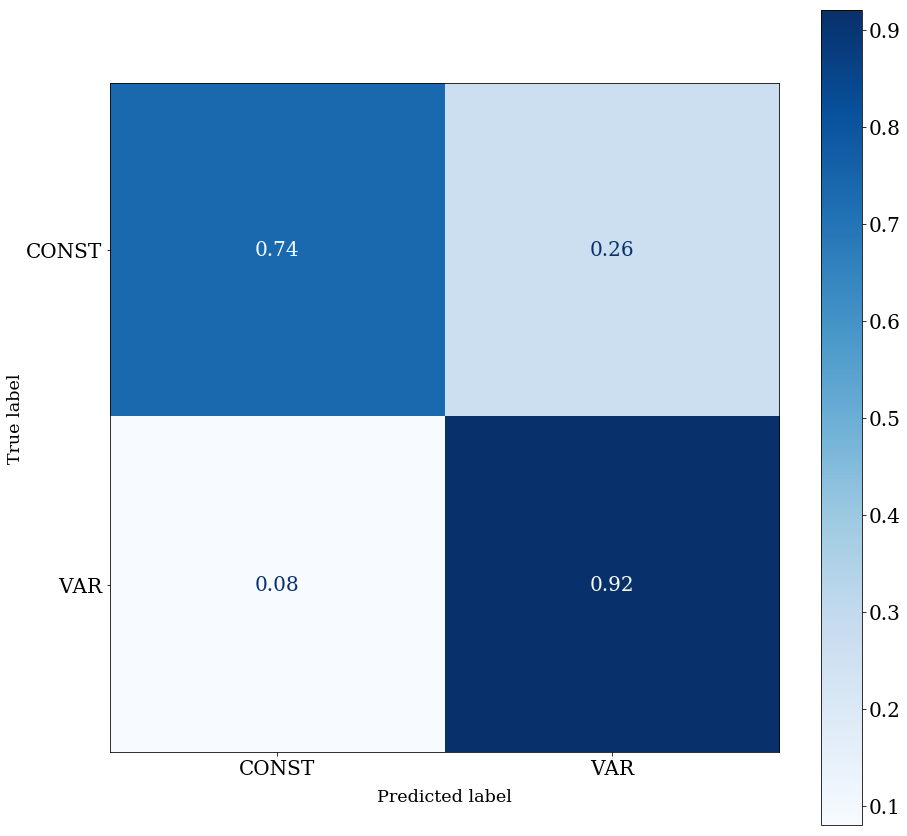

In [114]:
fig1 = classif_report(model, y_test, y_pred, X_test)

In [24]:
features_dict = {}
for i in range(len(model.feature_importances_)):
    features_dict[data_cols[i]] = model.feature_importances_[i]

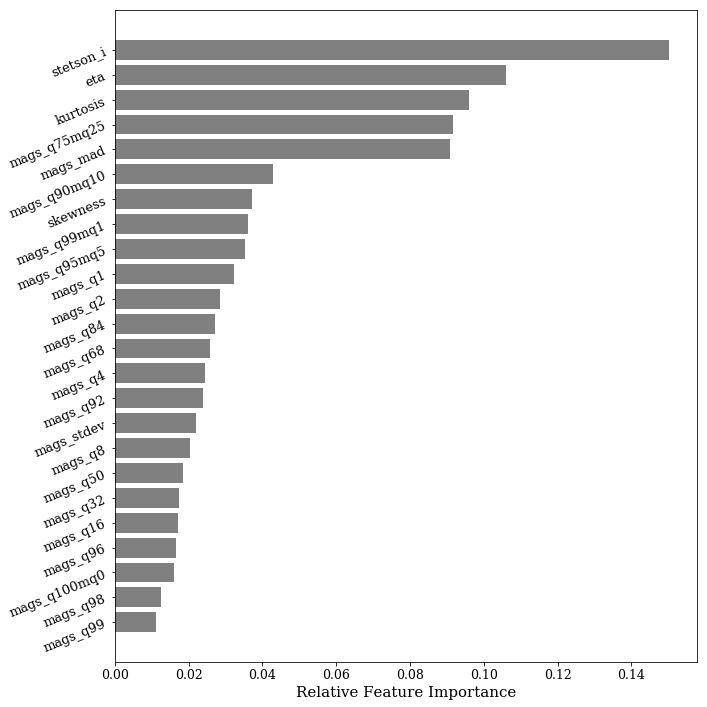

<module 'matplotlib.pyplot' from '/opt/ioa/software/anaconda/anaconda36/envs/20200117_py36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [25]:
def plot_imp(imp_dict):
    sort_dict = {k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1], reverse=True)}
    feat_names = list(sort_dict.keys())
    feat_imp = np.array(list(sort_dict.values()))
    y_pos = np.arange(len(feat_names))
    
    fig = plt.figure( figsize=(10,10))
    plt.barh(np.arange(0, len(feat_imp)), feat_imp, color='grey', align='center')
    plt.yticks(np.arange(0, len(feat_imp)), feat_names, rotation=22.5, family='serif', fontsize=13)
    plt.xlabel('Relative Feature Importance', family='serif', fontsize=15)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    fig.savefig('bin_feat_imp.png')
    return plt

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12.5}


matplotlib.rc('font', **font)
plot_imp(features_dict)

## Random Forest Test - MULTI-CLASS case

In [24]:
multi_train_const = select_df(full, 'CONST')
multi_train_ew = select_df(c_samp, 'EW')
multi_train_ea = select_df(nc_samp, 'EA/EB')
multi_train_ell = select_df(ell_samp, 'ELL')
multi_train_ab = select_df(ab_samp, 'rrAB')
multi_train_lc = select_df(lc_samp, 'rrC/D')

76382 CONST train class
20000 EW train class
20000 EA/EB train class
12906 ELL train class
15279 rrAB train class
6458 rrC/D train class


In [26]:
multi_frames = [multi_train_const, multi_train_ew, multi_train_ea, multi_train_ell,
          multi_train_ab, multi_train_lc]
for i in frames:
    i.replace([np.inf, -np.inf], np.nan, inplace=True)
    i.dropna(axis=0, how='any', inplace=True)
    print('{} {} sources'.format(len(i), set(i['class'])))
    
multi_train_df = pd.concat(frames)
print(len(train_df))

76243 {'CONST'} sources
4855 {'EW'} sources
1355 {'EA/EB'} sources
7733 {'ELL'} sources
9396 {'rrAB'} sources
4160 {'rrC/D'} sources
103531


In [27]:
X_multi = multi_train_df[data_cols]
y_multi = multi_train_df[target_cols]

In [29]:
X_train_mul, X_test_mul, y_train_mul, y_test_mul = train_test_split(X_multi,
                                                    y_multi, test_size=0.25, random_state=42)

In [30]:
sc_multi = StandardScaler()
X_train_mul = sc_multi.fit_transform(X_train_mul)
X_test_mul = sc_multi.transform(X_test_mul)

In [32]:
model_mul = RandomForestClassifier(n_estimators=1000, min_samples_split=5, min_samples_leaf=5, max_features='sqrt',
                                    max_depth=18, class_weight='balanced_subsample')
model_mul.fit(X_train_mul, y_train_mul.values.ravel())
y_pred_mul = model.predict(X_test_mul)

[[9446    0    0    0 9707    0    0]
 [   0    0    0    0  352    0    0]
 [ 162    0    0    0 1704    0    0]
 [   0    0    0    0 1232    0    0]
 [   0    0    0    0    0    0    0]
 [  18    0    0    0 2323    0    0]
 [  31    0    0    0  961    0    0]]


/home/tam68/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tam68/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       CONST       0.98      0.49      0.66     19153
       EA/EB       0.00      0.00      0.00       352
         ELL       0.00      0.00      0.00      1866
          EW       0.00      0.00      0.00      1232
         VAR       0.00      0.00      0.00         0
        rrAB       0.00      0.00      0.00      2341
       rrC/D       0.00      0.00      0.00       992

    accuracy                           0.36     25936
   macro avg       0.14      0.07      0.09     25936
weighted avg       0.72      0.36      0.48     25936



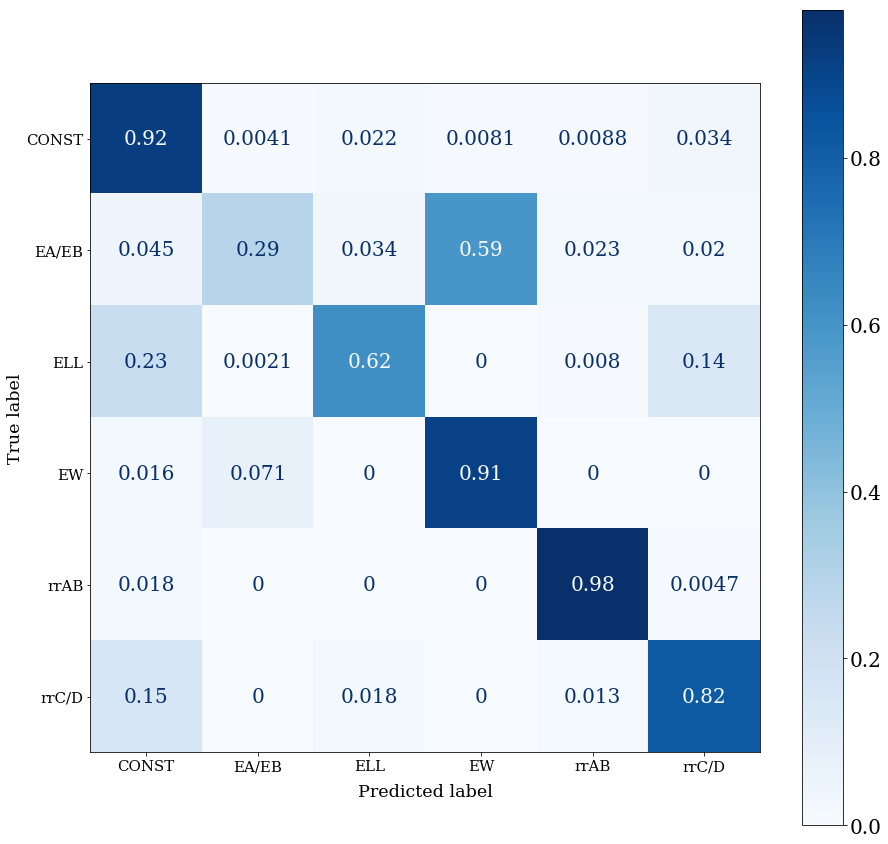

In [ ]:
fig2 = classif_report(model_mul, y_test_mul, y_pred_mul, X_test_mul)

## Extract candidate sources by applying classifier on b334 tile

In [115]:
tile_data = pd.read_pickle('b305.pkl')
print('{} tile sources'.format(len(tile_data)))

4269762 tile sources


In [116]:
# Normalise input data to training data distribution (i.e. model specifications)
sc = StandardScaler()
X_full = sc.fit_transform(X)
tile_data_norm = sc.transform(tile_data[data_cols])

In [117]:
model_full = RandomForestClassifier(n_estimators=1000, min_samples_split=5, min_samples_leaf=5, max_features='sqrt',
                                    max_depth=18, class_weight='balanced_subsample')
model_full.fit(X_full, y.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=18, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [ ]:
tile_data_prediction = model_full.predict(tile_data_norm)
tile_data_probabilities = model_full.predict_proba(tile_data_norm)

In [ ]:
inp = {'sourceid': trial_data['sourceid'], 'prediction': trial_data_prediction,
       'probability_const': [i[0] for i in trial_data_probabilities], 'probability_var': [i[1] for i in trial_data_probabilities]}

b305_predictions = pd.DataFrame(data=inp)

for i in model_full._classes:
    curr = b305_predictions.loc[b305_predictions['prediction']=='{}'.format(i)]
    print('{} {} sources found'.format(len(curr), i))

## Analyse tile classification results (for both b334 and b305)

## b305

In [6]:
use = pd.read_pickle('b305_predictions.pkl')

2438981


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68b63162e8>]],
      dtype=object)

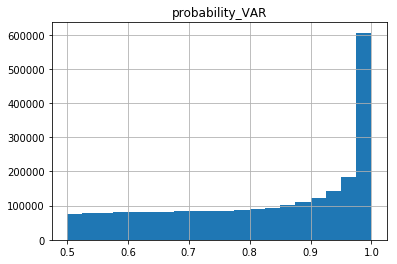

In [21]:
var = use.loc[use['prediction']=='VAR'].copy()
print(len(var))
var_probs = var[['probability_VAR']]
var_probs.hist(bins=20)

In [23]:
var_highprob = var.drop(var[var['probability_VAR']<0.9].index)
print(len(var_highprob))

1056541


In [31]:
test_ids = var_highprob[:10].copy()

In [33]:
test_ids.to_pickle('test_ids.pkl')

In [38]:
import main_cand_feats

In [40]:
import importlib
importlib.reload(main_cand_feats)

<module 'main_cand_feats' from '/home/tam68/astro_project/lc_stats/main_cand_feats.py'>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68ba3b0a90>]],
      dtype=object)

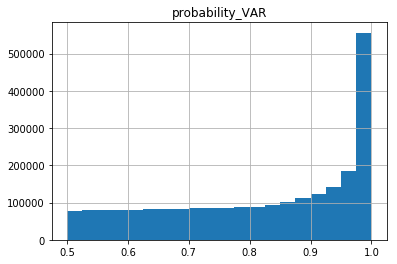

In [12]:
var_nu = var_probs.drop(var_probs[var_probs['probability_VAR']==1.0].index)
var_nu.hist(bins=20)

In [13]:
for i in 

         probability_VAR
2125165         0.999999
803107          0.999999
4536757         0.999999
299813          0.999997
3205631         0.999996
...                  ...
4552721         0.500002
4287477         0.500001
3515539         0.500001
2191084         0.500001
447388          0.500000

[2388896 rows x 1 columns]


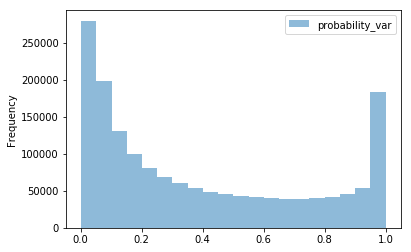

In [52]:
use.plot.hist(bins=20, alpha=0.5)

## b334

In [14]:
b334_use = pd.read_pickle('b334_prelim_predictions.pkl')

In [18]:
ids_unit = b334_use.loc[b334_use['probability_var']==1.0].copy()['sourceid']
print(ids_unit)

557        582902150435
1202       582903005677
1245       580853008082
2182       582903174068
3694       582903006271
               ...     
1674037    575737120837
1674051    574713143303
1674061    574713083579
1674149    572663168874
1674237    574713026700
Name: sourceid, Length: 23769, dtype: int64


In [20]:
test = pd.DataFrame(data={'sourceid': ids_unit})
test.to_pickle('unit_idsb334.pkl')

In [54]:
print(b334_candidates)

             sourceid prediction  probability_const  probability_var
6        580852028322        VAR           0.027087         0.972913
39       583926088702        VAR           0.071440         0.928560
46       580852088217        VAR           0.093049         0.906951
71       582902150076        VAR           0.087740         0.912260
76       581877056301        VAR           0.037831         0.962169
...               ...        ...                ...              ...
1674214  572663047237        VAR           0.006718         0.993282
1674215  572663132196        VAR           0.048608         0.951392
1674219  575737080126        VAR           0.047183         0.952817
1674220  574712160102        VAR           0.099689         0.900311
1674237  574713026700        VAR           0.000000         1.000000

[237843 rows x 4 columns]


In [55]:
b334_candidates.to_pickle('b334_candidates.pkl')